# Bayesian linear regression example

Good old fashioned, handful of parameters linear regressions are great!

Don't get me wrong I love fitting larger machine learning (ML) models and when you're after raw predictive power there's nothing better than finally getting that  huge neural networking singing. But in so many applications where you would employ data-driven models, linear regression models (and variations thereof) can hold their own and often be better suited to the project as a whole. 

There's something very tangible about knowing all the parameters in your model. A tight knit group that you can all call friends when you push that final model to your github repo. As ML models get larger, at best they're are filled with acquaintances. More often you're left anxiously gazing into the black-box abyss just hoping to recognise a friendly face.

For a while now my default fit for linear regressions has been Bayesian. Sure uncertainty quanitifcation is :fire:, but really it's the flexibility afforded by a Bayesian framework which lets you guide and extend on simple models to provide just the right level of complexity. Actually this post is really a vehicle to a future post which will dive into some of this flexibility and really show off the interesting aspect (hint: it'll be plenty hierarchical). But we have to get on the bus somewhere, and this is the stop closest to home. 

I will say though, that you pay for all these flashy uncertainty band with a (mostly very modest) computational cost. Sometimes it can sneak up on you for more complex models, but for a lot of problems in the environmental space the time difference is small on modern compute. I've skimmed through enough articles to know attention spans are shorter than ever, or something to that effect, but surely we can spare a extra seconds to give our model a glow up.

Anyway I hear you, be quiet now and show me some data.



Data-driven modelling of coastal storm erosion for real-time forecasting at a wave-dominated embayed beach (Ibaceta and Harley, 2024)
https://doi.org/10.1016/j.coastaleng.2024.104596

This notebook shows the use of simple multi-linear regressions to predict storm erosion (Figure 8 of the paper). Future users of this notebook could generate similar models using their shoreline data and forcing variables following the format of theattached data.

Data (data.csv)
The explanatory variables (offshore wave forcing) and resulting dW (columns) for each beach region (exposed, partially-exposed and sheltered) are stored for each storm event (rows).

In [1]:
import os
# cpu cores for sampling
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=3'

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error


In [2]:
# Load data from Rai's github repository for the aforementioned paper
fn = 'https://raw.githubusercontent.com/raiibacetav/data-driven-storm-erosion/refs/heads/main/data.csv'
df_storms = pd.read_csv(fn, index_col = 0)

In [3]:
#Obtain multi-linear regression model and plot
cases = [ 'dW_exposed','dW_partially', 'dW_sheltered']
CASES = ['Exposed','Partially-exposed', 'Sheltered'] #for labeling purposes


# Reimplement with NP

In [4]:
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# NumPyro for proabilistic programming
import arviz as az
from jax import random
import jax
import jax.numpy as jnp
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive

In [5]:
df_storms

,Onset,End,timezone,Eocum,Dpo,Tpeak,WLres,Wpre_exposed,Wpre_partially,Wpre_sheltered,dW_exposed,dW_partially,dW_sheltered
0,8/04/1992 1:00,8/04/1992 12:00,AEST,90269.79082,175.749732,11.76,0.027544,NaN,NaN,NaN,NaN,NaN,NaN
1,22/05/1992 17:00,23/05/1992 11:00,AEST,144482.56750,161.495057,13.33,0.115056,NaN,NaN,NaN,NaN,NaN,NaN
2,28/06/1992 11:00,29/06/1992 1:00,AEST,98014.92003,128.537159,11.11,0.168360,NaN,NaN,NaN,NaN,NaN,NaN
3,20/07/1992 18:00,21/07/1992 20:00,AEST,200767.37930,169.340229,10.52,0.198119,NaN,NaN,NaN,NaN,NaN,NaN
4,26/07/1992 3:00,26/07/1992 18:00,AEST,118893.62860,172.283891,12.50,0.020682,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,21/09/2021 14:00,22/09/2021 8:00,AEST,144237.83400,177.536986,11.45,0.233995,46.250373,40.293523,34.091311,0.094805,-0.227373,0.724766
460,14/10/2021 18:00,15/10/2021 1:00,AEST,35775.98247,61.743952,9.32,0.213986,54.010591,NaN,NaN,1.522911,NaN,NaN
461,26/10/2021 1:00,26/10/2021 12:00,AEST,66642.85300,166.414028,12.93,0.136484,NaN,NaN,NaN,NaN,NaN,NaN
462,26/11/2021 14:00,29/11/2021 1:00,AEST,477040.79480,160.530772,12.14,0.255739,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
cases = [ 'dW_exposed','dW_partially', 'dW_sheltered']
CASES = ['Exposed','Partially-exposed', 'Sheltered'] #for labeling purposes

avg_dir = 135 #in degrees
df =  df_storms.copy()
df['sinDrel'] = np.sin((df['Dpo']-avg_dir)*np.pi/180)

id_vars = ['Eocum','WLres','Tpeak','sinDrel']
pre_vars = ['Wpre{}'.format(_[2:]) for _ in cases]
df =  df[id_vars+pre_vars+cases]

#renaming
# df.columns = ['CumEOff', 'WLres','Tpeak','sinDrel','Wpre', 'dW']

df = pd.melt(df, id_vars = id_vars + pre_vars).reset_index(drop=True)

# were going to do this in a lazy way
for ii in np.arange(df.shape[0]):
    df.loc[ii,'Wpre'] = df.loc[ii,'Wpre{}'.format(df.loc[ii,'variable'][2:])] 

df = df.drop(columns=pre_vars)
df =  df.dropna().reset_index(drop=True)
df

X = jnp.array(df[id_vars+['Wpre']].values)
cat = jnp.array(df['variable'].astype('category').cat.codes).astype(jnp.int32)
y = jnp.array(df['value'].values)

X = (X - X.mean(axis=0))/X.mean(axis=0)

y_mean = y.mean() 
y_scale = y.std() 
y = (y-y_mean)/y_scale

n_cat = df['variable'].astype('category').cat.codes.max()+1


In [8]:
def linear_model_simple(X,cat,y=None):
    '''
    Define linear model with priors for the parameters and model error
    Inputs:
        energy: storm energy
        dshl: observed shoreline change
    '''
    # Define priors
    with numpyro.plate("cats", n_cat):
        intercept = numpyro.sample("intercept",dist.Normal(0, 10)) 
        b_Eocum = numpyro.sample("b_Eocum",dist.Normal(0, 10)) 
        b_WLres = numpyro.sample("b_WLres",dist.Normal(0, 10))
        b_Tpeak = numpyro.sample("b_Tpeak",dist.Normal(0, 10))
        b_sinDrel = numpyro.sample("b_sinDrel",dist.Normal(0, 10))
        b_Wpre = numpyro.sample("b_Wpre",dist.Normal(0, 10)) 
    # jax.debug.print("{}",b_WLres)
        sigma = numpyro.sample("sigma",dist.Exponential(1))

    # jax.debug.print("{}",intercept[cat])

    mu = b_Eocum[cat] * X[:,0] + b_WLres[cat] * X[:,1] + b_Tpeak[cat] * X[:,2] + b_sinDrel[cat] * X[:,3] + b_Wpre[cat] * X[:,4] + intercept[cat]

    # store the model prediction before we account for the error
    numpyro.deterministic("mu", mu)
    # and then finally sample so we can compare to our observations
    numpyro.sample("y_out", dist.Normal(mu, sigma[cat]), obs=y)

In [9]:
def linear_model(X,cat,y=None):
    '''
    Define linear model with priors for the parameters and model error
    Inputs:
        energy: storm energy
        dshl: observed shoreline change
    '''

    intercept_bar = numpyro.sample("intercept_bar",dist.Normal(0, 10)) 
    b_Eocum_bar = numpyro.sample("b_Eocum_bar",dist.Normal(0, 10)) 
    b_WLres_bar = numpyro.sample("b_WLres_bar",dist.Normal(0, 10))
    b_Tpeak_bar = numpyro.sample("b_Tpeak_bar",dist.Normal(0, 10))
    b_sinDrel_bar = numpyro.sample("b_sinDrel_bar",dist.Normal(0, 10))
    b_Wpre_bar = numpyro.sample("b_Wpre_bar",dist.Normal(0, 10)) 

    # Define priors
    tau = 0.1
    with numpyro.plate("cats", n_cat):
        intercept = numpyro.sample("intercept",dist.Normal(intercept_bar, tau)) 
        b_Eocum = numpyro.sample("b_Eocum",dist.Normal(b_Eocum_bar, tau)) 
        b_WLres = numpyro.sample("b_WLres",dist.Normal(b_WLres_bar, tau))
        b_Tpeak = numpyro.sample("b_Tpeak",dist.Normal(b_Tpeak_bar, tau))
        b_sinDrel = numpyro.sample("b_sinDrel",dist.Normal(b_sinDrel_bar, tau))
        b_Wpre = numpyro.sample("b_Wpre",dist.Normal(b_Wpre_bar, tau)) 

    # jax.debug.print("{}",b_WLres)
        sigma = numpyro.sample("sigma",dist.Exponential(1))

    # jax.debug.print("{}",intercept[cat])

    mu = b_Eocum[cat] * X[:,0] + b_WLres[cat] * X[:,1] + b_Tpeak[cat] * X[:,2] + b_sinDrel[cat] * X[:,3] + b_Wpre[cat] * X[:,4] + intercept[cat]

    # store the model prediction before we account for the error
    numpyro.deterministic("mu", mu)
    # and then finally sample so we can compare to our observations
    numpyro.sample("y_out", dist.Normal(mu, sigma[cat]), obs=y)

In [10]:
# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)
# here take 100 samples from our priors and make predictions on x_log
prior_samples = Predictive(linear_model, num_samples=500)(
    rng_key_, X=X, cat=cat
)
prior_samples = {k: jnp.expand_dims(v,axis=0) for k, v in prior_samples.items()}
# and put this into arviz for easy plotting
arviz_priors = az.from_dict(
    prior=prior_samples
)
arviz_priors

Inference data with groups:
	> prior

In [11]:
var_names = ['b_{}'.format(_) for _ in id_vars]

################################################################################
Priors


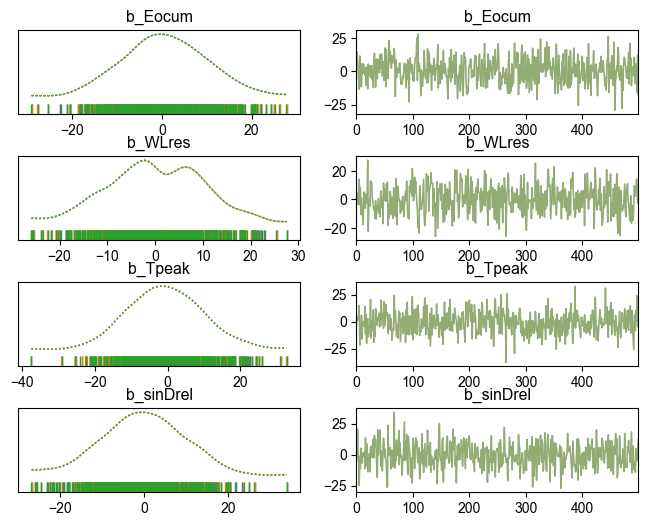

In [12]:
# and now plot the distributions and the simulated data
print('#'*80)
print('Priors')
priors_ax = az.plot_trace(
    arviz_priors.prior, 
    var_names=var_names,
    figsize=(8,6),
    rug=True,
    show=False,
    combined=True
)
# make it readable
plt.subplots_adjust(hspace=0.5)
plt.show()

# Now lets sample

In [13]:
# settings 
num_samples = 1000
num_warmup = num_samples
num_chains = 3
ci = 0.89

# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)

# define the sampler - No U-Turn Sampler (NUTS)
kernel = NUTS(linear_model)

# define the mcmc wrapper
mcmc_obj = MCMC(
    kernel, 
    num_warmup=num_warmup, 
    num_samples=num_samples,
    num_chains=num_chains
)

# now run the sampler for num_samples+burnin
mcmc_obj.run(
    rng_key_, X=X, cat=cat, y=y
)
mcmc_obj.print_summary()
# get the samples which will form our posterior
samples = mcmc_obj.get_samples()

# get the samples for predictive uncertainty (our linear model + error)
posterior_predictive = Predictive(linear_model, samples)(
    rng_key_, X=X, cat=cat, y=y
)

# get the mean model prediciton
mean_mu = jnp.mean(posterior_predictive['mu'], axis=0)
# hpdi is used to compute the credible intervals corresponding to ci
hpdi_mu = hpdi(posterior_predictive['mu'], ci)
hpdi_sim_y = hpdi(posterior_predictive['y_out'], ci)

arviz_posterior = az.from_numpyro(
    mcmc_obj,
    prior=prior_samples,
    posterior_predictive=posterior_predictive,
)
# arviz_posterior

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
     b_Eocum[0]      0.62      0.08      0.62      0.49      0.76   2693.45      1.00
     b_Eocum[1]      0.61      0.05      0.61      0.52      0.68   2142.83      1.00
     b_Eocum[2]      0.40      0.04      0.40      0.33      0.48   2039.85      1.00
    b_Eocum_bar      0.54      0.07      0.54      0.43      0.66   2161.22      1.00
     b_Tpeak[0]      0.49      0.25      0.49      0.09      0.92   1041.52      1.00
     b_Tpeak[1]      0.50      0.24      0.51      0.15      0.94   1015.58      1.00
     b_Tpeak[2]      0.39      0.23      0.39      0.02      0.78   1039.43      1.00
    b_Tpeak_bar      0.46      0.24      0.47      0.07      0.84    964.06      1.00
     b_WLres[0]      0.16      0.11      0.16     -0.04      0.33   2159.41      1.00
     b_WLres[1]      0.02      0.08      0.02     -0.12      0.13   2262.08      1.00
     b_WLres[2]     -0.01      0.07     -0.01     -0.

In [14]:
# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)

# define the sampler - No U-Turn Sampler (NUTS)
kernel = NUTS(linear_model_simple)

# define the mcmc wrapper
mcmc_obj_simple = MCMC(
    kernel, 
    num_warmup=num_warmup, 
    num_samples=num_samples,
    num_chains=num_chains
)

# now run the sampler for num_samples+burnin
mcmc_obj_simple.run(
    rng_key_, X=X, cat=cat, y=y
)
mcmc_obj_simple.print_summary()
# get the samples which will form our posterior
samples_simple = mcmc_obj.get_samples()

# get the samples for predictive uncertainty (our linear model + error)
posterior_predictive_simple = Predictive(linear_model_simple, samples_simple)(
    rng_key_, X=X, cat=cat, y=y
)

# get the mean model prediciton
mean_mu_simple = jnp.mean(posterior_predictive_simple['mu'], axis=0)
# hpdi is used to compute the credible intervals corresponding to ci
hpdi_mu_simple = hpdi(posterior_predictive_simple['mu'], ci)
hpdi_sim_y_simple = hpdi(posterior_predictive_simple['y_out'], ci)

arviz_posterior_simple = az.from_numpyro(
    mcmc_obj_simple,
    posterior_predictive=posterior_predictive_simple,
)
# arviz_posterior

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  b_Eocum[0]      0.47      0.13      0.47      0.26      0.69   2164.72      1.00
  b_Eocum[1]      0.62      0.06      0.62      0.53      0.71   2502.21      1.00
  b_Eocum[2]      0.41      0.05      0.41      0.32      0.49   2713.91      1.00
  b_Tpeak[0]      2.35      0.88      2.36      1.01      3.88   2844.71      1.00
  b_Tpeak[1]      0.97      0.34      0.96      0.41      1.52   3408.56      1.00
  b_Tpeak[2]     -0.17      0.31     -0.18     -0.65      0.34   2983.63      1.00
  b_WLres[0]      0.41      0.21      0.40      0.06      0.75   2493.92      1.00
  b_WLres[1]     -0.07      0.10     -0.07     -0.22      0.09   2616.33      1.00
  b_WLres[2]     -0.01      0.08     -0.01     -0.13      0.14   2263.40      1.00
   b_Wpre[0]      1.56      0.35      1.56      1.00      2.14   3031.73      1.00
   b_Wpre[1]      1.26      0.19      1.26      0.91      1.54   3290.41      1.00
   

################################################################################
Posterior


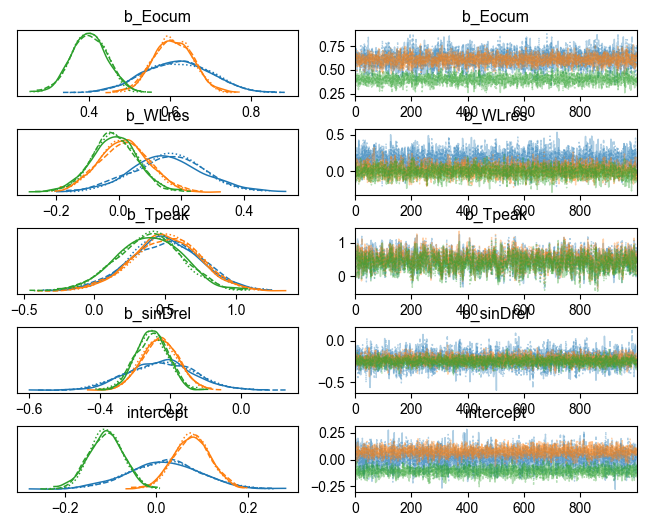

In [15]:
print('#'*80)
print('Posterior')
az.plot_trace(
    arviz_posterior,
    var_names=var_names + ['intercept'],
    figsize=(8,6),
    show=False
)
# make it readable
plt.subplots_adjust(hspace=0.5)
plt.show()

################################################################################
Posterior


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

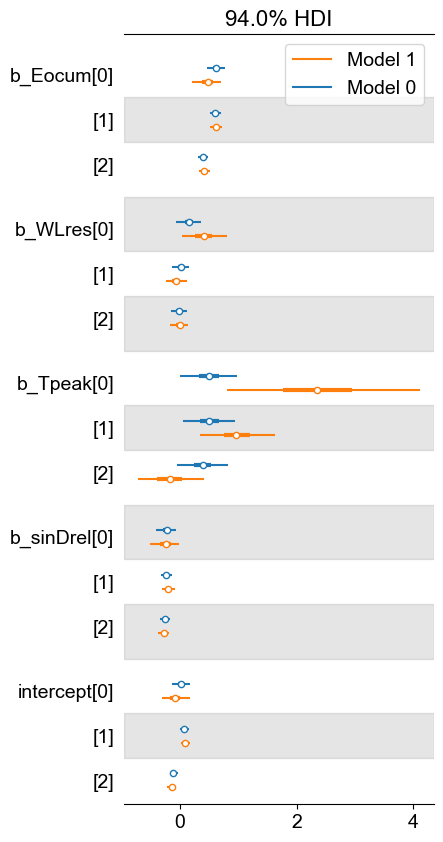

In [16]:
print('#'*80)
print('Posterior')
az.plot_forest(
    [arviz_posterior, arviz_posterior_simple],
    var_names=var_names+ ['intercept'],
    figsize=(4,10),
    combined=True
)

In [17]:
results_df = df[['variable','value']].copy()
results_df['mod_y'] = mean_mu * y_scale + y_mean
results_df
results_df_simple  = df[['variable','value']].copy()
results_df_simple ['mod_y'] = mean_mu_simple * y_scale + y_mean
results_df_simple 

,variable,value,mod_y
0,dW_exposed,0.000000,5.707088
1,dW_exposed,0.000000,-0.317062
2,dW_exposed,-0.879114,-3.804118
3,dW_exposed,6.864748,4.785661
4,dW_exposed,3.645248,3.359665
...,...,...,...
592,dW_sheltered,8.423833,3.339396
593,dW_sheltered,-4.315257,-3.650889
594,dW_sheltered,4.651117,2.658271
595,dW_sheltered,7.236904,2.221103


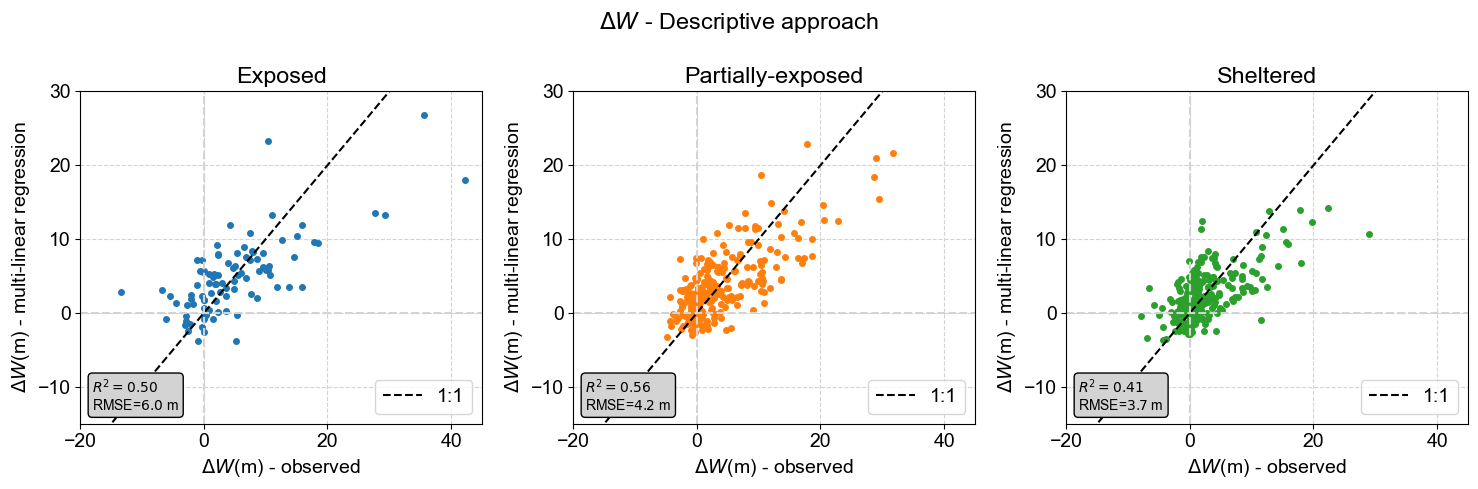

In [18]:
fig,axs = plt.subplots(1,3,figsize = (15,5))
axs =  axs.ravel()
RMSE = [] 
R2   = []
colors = ['tab:blue','tab:orange','tab:green']
storms = []
for i,case in enumerate(cases):
    case_results_df = results_df[results_df['variable']==case]
    score = r2_score(case_results_df['value'].values,case_results_df['mod_y'].values) #Coef of determination
    rmse = np.sqrt(mean_squared_error(case_results_df['value'].values,case_results_df['mod_y'].values)) #root mean squared error

    #Plot
    textstr = '\n'.join((r'$R^{2}=%.2f$' % (score, ),
                            r'RMSE=$%.1f$ m' % (rmse, )))
    props = dict(boxstyle='round', facecolor='lightgrey')
    axs[i].text(0.03, 0.14, textstr, transform=axs[i].transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    axs[i].plot(case_results_df['value'].values,case_results_df['mod_y'].values,'.', label = None, color = colors[i],markersize=8)
    axs[i].plot(np.arange(-30,45,0.5),np.arange(-30,45,0.5),linestyle = 'dashed', color = 'black',label = '1:1')
    axs[i].set_xlim([-20,45])
    axs[i].set_ylim([-15,30])
    axs[i].axvline(x=0, color = 'lightgrey', linestyle = 'dashed')
    axs[i].axhline(y=0, color = 'lightgrey', linestyle = 'dashed')
    axs[i].set_xlabel(r'$\Delta W$'+'(m) - observed')
    axs[i].set_ylabel(r'$\Delta W$'+'(m) - multi-linear regression')
    axs[i].legend(loc = 'lower right')
    axs[i].set_title(CASES[i])  

    fig.suptitle(r'$\Delta W$' + ' - Descriptive approach')
    for ax in axs:
        ax.grid(linestyle = 'dashed', color = 'lightgrey')
    plt.tight_layout()
plt.show()

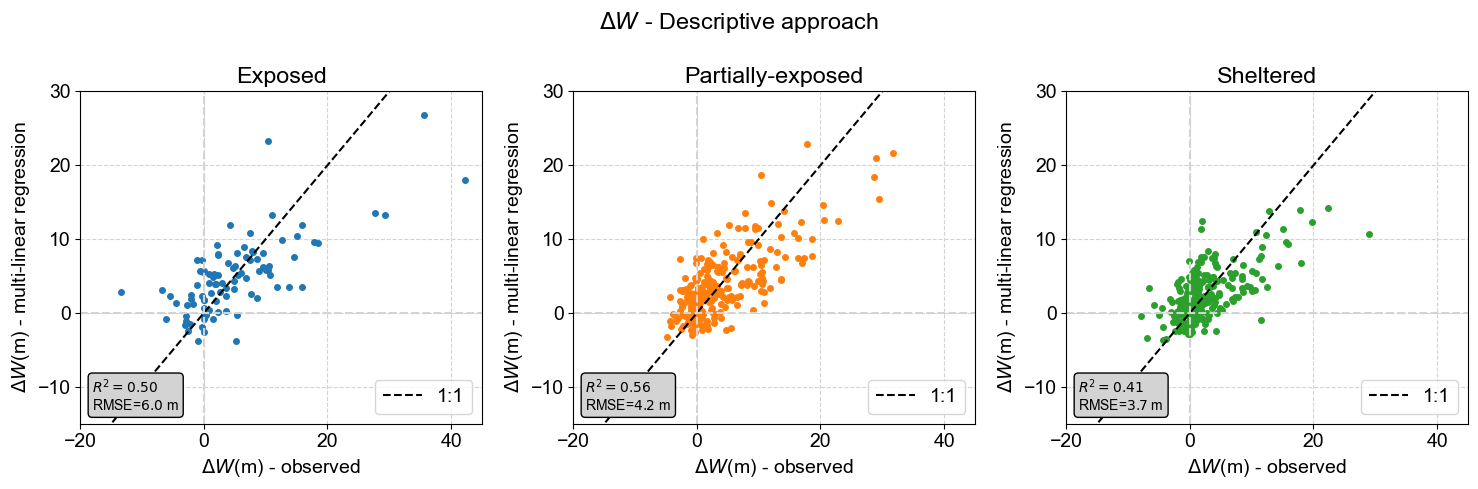

In [19]:
fig,axs = plt.subplots(1,3,figsize = (15,5))
axs =  axs.ravel()
RMSE = [] 
R2   = []
colors = ['tab:blue','tab:orange','tab:green']
storms = []
for i,case in enumerate(cases):
    case_results_df = results_df_simple[results_df_simple['variable']==case]
    score = r2_score(case_results_df['value'].values,case_results_df['mod_y'].values) #Coef of determination
    rmse = np.sqrt(mean_squared_error(case_results_df['value'].values,case_results_df['mod_y'].values)) #root mean squared error

    #Plot
    textstr = '\n'.join((r'$R^{2}=%.2f$' % (score, ),
                            r'RMSE=$%.1f$ m' % (rmse, )))
    props = dict(boxstyle='round', facecolor='lightgrey')
    axs[i].text(0.03, 0.14, textstr, transform=axs[i].transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    axs[i].plot(case_results_df['value'].values,case_results_df['mod_y'].values,'.', label = None, color = colors[i],markersize=8)
    axs[i].plot(np.arange(-30,45,0.5),np.arange(-30,45,0.5),linestyle = 'dashed', color = 'black',label = '1:1')
    axs[i].set_xlim([-20,45])
    axs[i].set_ylim([-15,30])
    axs[i].axvline(x=0, color = 'lightgrey', linestyle = 'dashed')
    axs[i].axhline(y=0, color = 'lightgrey', linestyle = 'dashed')
    axs[i].set_xlabel(r'$\Delta W$'+'(m) - observed')
    axs[i].set_ylabel(r'$\Delta W$'+'(m) - multi-linear regression')
    axs[i].legend(loc = 'lower right')
    axs[i].set_title(CASES[i])  

    fig.suptitle(r'$\Delta W$' + ' - Descriptive approach')
    for ax in axs:
        ax.grid(linestyle = 'dashed', color = 'lightgrey')
    plt.tight_layout()
plt.show()

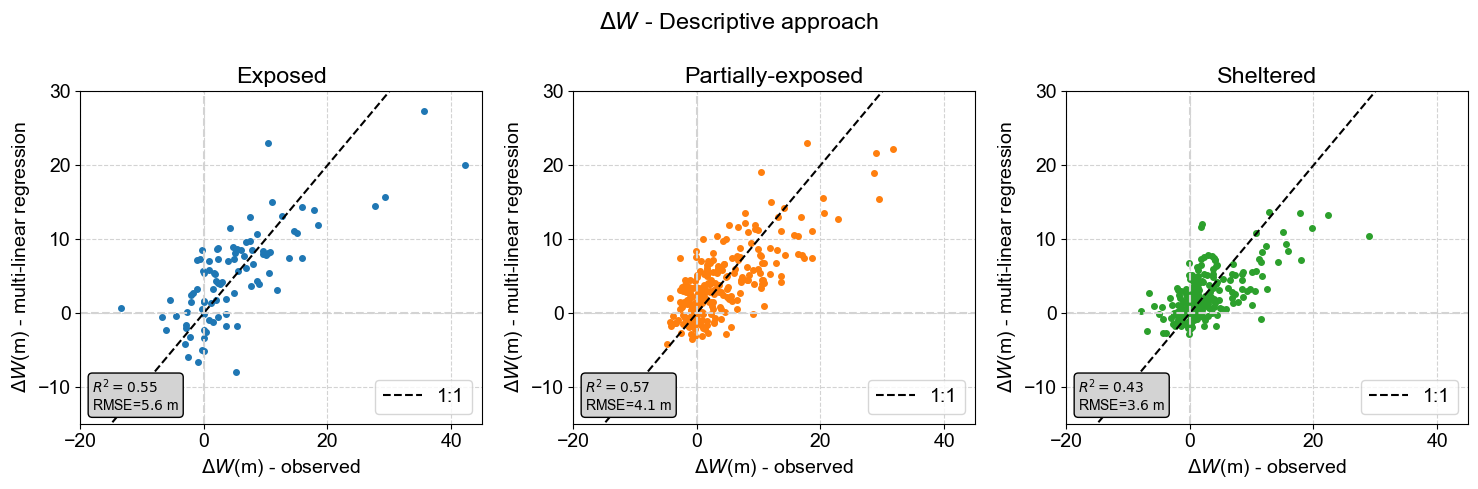

In [20]:

fig,axs = plt.subplots(1,3,figsize = (15,5))
axs =  axs.ravel()
RMSE = [] 
R2   = []
colors = ['tab:blue','tab:orange','tab:green']
storms = []

for i,case in enumerate(cases):
    
    casewi = 'Wpre'+case[2:]
    df =  df_storms.copy()
    df['sinDrel'] = np.sin((df['Dpo']-avg_dir)*np.pi/180)
    
    df =  df[['Eocum','WLres','Tpeak','sinDrel',casewi, case]]
    
    #renaming
    df.columns = ['CumEOff', 'WLres','Tpeak','sinDrel','Wpre', 'dW']
    
    df =  df.dropna()   

    #Linear regression with intercept
    LR = LinearRegression(fit_intercept=True) 
    LR.fit(df[['CumEOff', 'WLres', 'Tpeak', 'sinDrel', 'Wpre']],df.dW)
    
    
    y_prediction =  LR.predict(df[['CumEOff', 'WLres', 'Tpeak', 'sinDrel', 'Wpre']])
    
    score=r2_score(df.dW,y_prediction) #Coef of determination
    rmse = np.sqrt(mean_squared_error(df.dW,y_prediction)) #root mean squared error
    
    #Plot
    
    textstr = '\n'.join((r'$R^{2}=%.2f$' % (score, ),
                         r'RMSE=$%.1f$ m' % (rmse, )))
    props = dict(boxstyle='round', facecolor='lightgrey')
    axs[i].text(0.03, 0.14, textstr, transform=axs[i].transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    axs[i].plot(df['dW'],y_prediction,'.', label = None, color = colors[i],markersize=8)
    axs[i].plot(np.arange(-30,45,0.5),np.arange(-30,45,0.5),linestyle = 'dashed', color = 'black',label = '1:1')
    axs[i].set_xlim([-20,45])
    axs[i].set_ylim([-15,30])
    axs[i].axvline(x=0, color = 'lightgrey', linestyle = 'dashed')
    axs[i].axhline(y=0, color = 'lightgrey', linestyle = 'dashed')
    axs[i].set_xlabel(r'$\Delta W$'+'(m) - observed')
    axs[i].set_ylabel(r'$\Delta W$'+'(m) - multi-linear regression')
    axs[i].legend(loc = 'lower right')
    axs[i].set_title(CASES[i])  

fig.suptitle(r'$\Delta W$' + ' - Descriptive approach')
for ax in axs:
    ax.grid(linestyle = 'dashed', color = 'lightgrey')
plt.tight_layout()

In [21]:
LR.coef_
LR.feature_names_in_

array(['CumEOff', 'WLres', 'Tpeak', 'sinDrel', 'Wpre'], dtype=object)